# Test out creating a simple LangGraph using its Components

A simple example of building an agent using LangGraph components. It demonstrates how to create a conversational agent that can search for information and respond to user queries using a state-based workflow.

This code is setting up the necessary imports and configurations to work with the OpenAI API in a Python environment.
This code is typically used at the beginning of a script that will make API calls to OpenAI services (like GPT models). The .env file would contain your API key and potentially other configuration values, which are loaded into environment variables for security (rather than hardcoding them in your script).


In [ ]:
import openai
import re
import httpx
import os
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Image
from dotenv import load_dotenv
from openai import OpenAI
from tavily import TavilyClient
_ = load_dotenv()

This code is setting up authentication for the OpenAI API
This is a standard pattern for setting up API clients securely. Instead of putting your API key directly in your code (which would be bad practice, especially if you share or publish the code), you store it in a separate .env file that isn't committed to version control. The code then loads this key at runtime.


In [ ]:


# Get OpenAI API key from environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")


# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)
tavily = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
print("Environment setup complete!")

This code checks if the OpenAI API key was successfully loaded from the environment variables and provides helpful instructions if it wasn't found. Here's what it does:
The if not OPENAI_API_KEY: condition checks if the API key variable is empty or None.
If the API key is missing, it prints a detailed set of instructions to help the user get set up:

Directs them to OpenAI's API key management page
Instructs them to create an account or log in
Tells them to create a new API key
Guides them to create a .env file in the project's root directory
Shows the exact format for adding the API key to the .env file
Reminds them to restart the notebook for the changes to take effect

If the API key is found (the else clause), it simply prints a confirmation message: "OpenAI API key found!"


In [ ]:
if not TAVILY_API_KEY:
    print("Tavily API key not found. Please follow these steps:")
    print("1. Go to https://tavily.com/api-keys")
    print("2. Create an account or log in")
    print("3. Create a new API key")
    print("4. Create a .env file in the root directory of this project")
    print("5. Add the following line to the .env file:")
    print("   TAVILY_API_KEY=your-api-key-here")
    print("6. Restart the notebook")
else:
    print("Tavily API key found!")

In [ ]:
if not OPENAI_API_KEY:
    print("OpenAI API key not found. Please follow these steps:")
    print("1. Go to https://platform.openai.com/account/api-keys")
    print("2. Create an account or log in")
    print("3. Create a new API key")
    print("4. Create a .env file in the root directory of this project")
    print("5. Add the following line to the .env file:")
    print("   OPENAI_API_KEY=your-api-key-here")
    print("6. Restart the notebook")
else:
    print("OpenAI API key found!")

StateGraph: This is the main class from LangGraph that allows you to build a directed graph for your agent's workflow. It manages state transitions between different components.

END: A special constant used to mark a terminal node in your graph. When the agent reaches this state, execution stops.
TypedDict: Helps create dictionary types with predefined keys and value types.

In this code, it's used to define the structure of your agent's state.
Annotated: A Python typing feature that lets you add metadata to type hints. Here it's used to specify how messages are combined (using the operator.add).

Provides standard operators as functions. In this code, operator.add is used to specify how message lists should be combined when states are merged.

These are different message types from LangChain that represent parts of a conversation:

- AnyMessage: Base type for any message
- SystemMessage: Instructions to the AI about how to behave
- HumanMessage: Messages from the user
- ToolMessage: Messages from tools reporting results back to the AI

This imports the OpenAI chat model interface from LangChain, which allows you to interact with models like GPT-3.5 and GPT-4.

Imports the Tavily search tool which lets your agent perform internet searches and get real-time information. This tool allows your agent to look up travel information to answer the user's questions.

Together, these imports provide the foundation for creating an agent with:

- A state-based workflow (StateGraph)
- Typed state management (TypedDict, Annotated)
- Conversation handling capabilities (message types)
- Access to a language model (ChatOpenAI)
- The ability to search for information (TavilySearchResults)

This is what enables your travel agent to maintain a conversation, process user requests, search for information, and provide informative responses.


In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

This code creates a search tool for your agent that allows it to search for information online.
Here's what it's doing:

- tool = TavilySearchResults(max_results=4) - Creates a new Tavily search tool, configured to return 4 results per search (instead of the default, which is likely fewer)

This tool acts as the agent's "eyes" to the internet - when the agent needs information about travel destinations, attractions, costs, or other facts that might not be in its training data, it can use this tool to search for up-to-date information


In [28]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

This code defines a custom data structure for storing the agent's state using Python's typing features.
Here's what it does:

class AgentState(TypedDict): creates a specialized dictionary type called AgentState that has predefined keys and value types.
messages: Annotated[list[AnyMessage], operator.add] defines a field called "messages" in this dictionary, with these characteristics:

It contains a list of AnyMessage objects (these are message objects from LangChain that could be from the user, assistant, or tools)
The Annotated with operator.add specifies how to combine message lists when merging states - they should be concatenated together

This structure is used by LangGraph to:

Keep track of the conversation history
Pass messages between different nodes in the graph
Determine what to do next based on the state

When your agent runs, this structure stores all messages exchanged, which allows the agent to maintain context throughout a conversation and make decisions based on the entire dialogue history.


In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

# Understanding the Agent Class: A ReAct Pattern Implementation

> **Note:** The `take_action` method includes special logic to handle LLM hallucinations. Even with function calling, language models occasionally return non-existent tool names. The agent simply instructs the LLM to try again—a key advantage of this agentic approach.

## Overview

The `Agent` class creates a structured decision-making system that enables an AI assistant to think, search for information, and respond intelligently to user queries.

## Architecture Components

### Constructor (`__init__`)

The constructor builds the agent's workflow graph:

- **Inputs**: Language model (e.g., GPT-4), tools list, and optional system prompt
- **Graph Structure**:
  - Creates a `StateGraph` using `AgentState` to manage conversation
  - Adds two primary nodes:
    - `"llm"`: Processes messages and makes decisions
    - `"action"`: Executes tools like web searches
  - Establishes decision flow:
    - From `"llm"`, checks if tool use is needed
    - If yes → `"action"` node
    - If no → `END` (conversation terminates)
    - Return path from `"action"` to `"llm"` for processing results
  - Sets `"llm"` as entry point
  - Compiles the graph into an executable workflow
  - Organizes tools in a dictionary for quick access
  - Binds tools to the model to enable function calling

### Key Methods

#### Decision Function (`exists_action`)

Determines whether to use tools or end the conversation:

- Examines the latest message
- Checks for tool calls requested by the model
- Returns `True` if tool calls exist, `False` otherwise

#### Language Model Function (`call_openai`)

Manages interactions with the language model:

- Retrieves conversation history from state
- Prepends system prompt if provided
- Invokes the model with all messages
- Returns the model's response as new state

#### Tool Execution Function (`take_action`)

Handles tool usage workflow:

- Extracts tool calls from the model's latest response
- For each tool call:
  - Logs the execution
  - Verifies tool existence
  - Returns error for invalid tools
  - Invokes valid tools with arguments
  - Wraps results in formatted `ToolMessage`
- Returns all tool results for model processing

## Agent Capabilities

This ReAct (Reasoning + Action) pattern enables the agent to:

1. Analyze user questions
2. Determine information needs
3. Search for required information
4. Process search results
5. Formulate comprehensive responses

The design allows for breaking complex questions into manageable steps while gathering necessary information along the way.


In [ ]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

Once this code executes, agentbot is ready to:

Accept travel-related questions from users
Process them through the GPT-3.5 Turbo model
Search the internet for current information using Tavily when needed
Follow the travel planning instructions and workflow defined in the prompt and graph structure

It's essentially configuring a specialized travel assistant that can leverage internet search to provide up-to-date information rather than relying solely on its pre-trained knowledge.


In [ ]:
prompt = """You are a smart travel planner. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(
    model_name="gpt-3.5-turbo",  # Note: model_name instead of model in some versions
    # Don't include any proxy settings
) #reduce inference cost
agentbot = Agent(model, [tool], system=prompt)

## Display the Agent Graph Structure


This approach creates a visualization showing:

The nodes in the graph (LLM and Action nodes)
The connections between them
The overall flow of the agent's decision process

The visualization is simpler than what Mermaid might provide, but it works reliably without external dependencies and clearly shows the ReAct pattern's flow between thinking (LLM) and acting (tools).


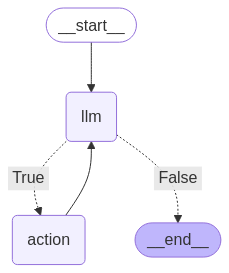

In [29]:
# Visualize the agent graph structure
from IPython.display import display, Image

# Render the graph as a Mermaid diagram and display it as a PNG image
display(
    Image(
        agentbot.graph.get_graph().draw_mermaid_png()
    )
)

# A Single Query and how it flows

This code is executing a query through your agent system using the LangGraph framework. Here's what it's doing:

messages = [HumanMessage(content="What is the capital in Namibia?")]

Creates a list containing a single HumanMessage with the question "What is the capital in Namibia?"
This represents the user's input to the agent

result = agentbot.graph.invoke({"messages": messages})

Calls the invoke method on the agent's graph
Passes the messages wrapped in a dictionary that matches the expected AgentState format
This starts the execution flow of the agent

Behind the scenes, this triggers:

The graph starts at the "llm" node (entry point)
The language model receives the question about Namibia's capital
If the model doesn't know the answer with certainty, it will likely call the Tavily search tool
The search results will be returned and passed back to the model
The model will process the information and formulate a final answer
The final result is stored in the result variable

You can then access the agent's final response with result['messages'][-1].content, which would tell you that Windhoek is the capital of Namibia.


In [ ]:
messages = [HumanMessage(content="What is the capital in Namibia?")]
result = agentbot.graph.invoke({"messages": messages})

In [ ]:
result

When you run result['messages'][-1].content, you're accessing the final message content from the conversation result. This extracts the agent's final answer about Namibia's capital from the complete state.
This line specifically:

Takes the result dictionary returned by the agent
Accesses the 'messages' list within that dictionary
Selects the last message [-1] (the agent's final response)
Extracts just the content of that message (the text of the answer)

The output would be something like:
"The capital of Namibia is Windhoek."
This is the clean, final answer generated by your agent after potentially searching for and processing information about Namibia.


In [ ]:
result['messages'][-1].content

First, it creates a new agent instance called agentbot:

pythonagentbot = Agent(model, [tool], system=prompt)

This agent uses the previously defined ChatGPT model, Tavily search tool, and travel planner system prompt.

Then it creates a list containing a single human message asking about two capitals:
pythonmessages = [HumanMessage(content="What is the Capital of Namibia and Botswana?")]

Finally, it invokes the agent's graph with these messages:
pythonresult = agentbot.graph.invoke({"messages": messages})

When this code runs, the agent will:

Process the question through the language model
Likely determine it needs to search for information (since the question asks about factual information)
Make one or more searches using the Tavily search tool
Process the search results
Formulate a complete answer about both capitals

The answer would be stored in the result variable, and you could access it using result['messages'][-1].content, which would tell you that the capital of Namibia is Windhoek and the capital of Botswana is Gaborone.


In [ ]:
# Create a new agent instance called 'agentbot'
agentbot = Agent(model, [tool], system=prompt)

messages = [HumanMessage(content="What is the Capital of Namibia and Botswana?")]
result = agentbot.graph.invoke({"messages": messages})

In [ ]:
result['messages'][-1].content

# Lets now ask a multi part Query and see how it flows

This will trigger the agent to:

Process the multi-part travel query
Likely make several searches to gather information on:

Seasonal information for Kyoto
Top attractions in Kyoto
Accommodation and food costs in Kyoto

Compile all this information
Structure a comprehensive response answering all three questions

Using GPT-4o allows the agent to better understand this complex query, manage multiple search results, and synthesize them into a coherent, well-structured answer about planning a trip to Kyoto.


In [30]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "What's the best time to visit Kyoto, Japan? What are the top 3 attractions there? \
How much would a typical 5-day trip cost for accommodation and food? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
agentbot = Agent(model, [tool], system=prompt)
result = agentbot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'best time to visit Kyoto Japan'}, 'id': 'call_NEJXwry1679EBRbjGZPni2zf', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'top 3 attractions in Kyoto'}, 'id': 'call_z11k5EZHDPklNSjozJx0UqTr', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'average cost for 5-day trip to Kyoto including accommodation and food'}, 'id': 'call_FAgOS5glsYtTW1BYlxKctWUK', 'type': 'tool_call'}
Back to the model!


In [31]:
print(result['messages'][-1].content)

### Best Time to Visit Kyoto, Japan

The best times to visit Kyoto are during the spring (March to May) and fall (September to November) months when the weather is mildest and you can enjoy the cherry blossoms and fall foliage. October is also a great time to visit, featuring cool and pleasant weather with fewer crowds and less rainfall. [Source](https://travel.usnews.com/Kyoto_Japan/When_To_Visit/)

### Top 3 Attractions in Kyoto

1. **Kiyomizudera Temple**: One of the most celebrated temples in Kyoto known for its magnificent view and historic significance.
2. **Fushimi Inari Shrine**: Famous for its thousands of vermillion torii gates, offering a memorable pathway up the mountain.
3. **Kinkakuji (The Golden Pavilion)**: A stunning Zen temple with its top two floors completely covered in gold leaf. [Source](https://www.quora.com/What-are-the-most-popular-tourist-attractions-in-Kyoto-and-why)

### Cost for a 5-Day Trip to Kyoto (Accommodation and Food)

A typical 5-day trip to Kyoto f